In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

trainset = torchvision.datasets.CIFAR10(root="D:/KMUTT/Year 4th/ENE490 DL/Coding/Dataset/RS/train", train=True, download=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="D:/KMUTT/Year 4th/ENE490 DL/Coding/Dataset/RS/test", train=False, download=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [3]:
class ResNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(ResNetClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(64 * 56 * 56, num_classes) 

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetClassifier(in_channels=3, num_classes=10).to(device)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
train_losses = []
test_losses = []
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(trainloader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_losses.append(test_loss / len(testloader))
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch 1/10, Train Loss: 12.4315, Test Loss: 7.1878
Epoch 2/10, Train Loss: 3.2456, Test Loss: 2.1528
Epoch 3/10, Train Loss: 1.5155, Test Loss: 1.5316
Epoch 4/10, Train Loss: 1.2940, Test Loss: 1.4673
Epoch 5/10, Train Loss: 1.2136, Test Loss: 1.4439
Epoch 6/10, Train Loss: 1.1578, Test Loss: 1.4795
Epoch 7/10, Train Loss: 1.1090, Test Loss: 1.4010
Epoch 8/10, Train Loss: 1.0751, Test Loss: 1.4697
Epoch 9/10, Train Loss: 1.0348, Test Loss: 1.5121
Epoch 10/10, Train Loss: 0.9947, Test Loss: 1.5390


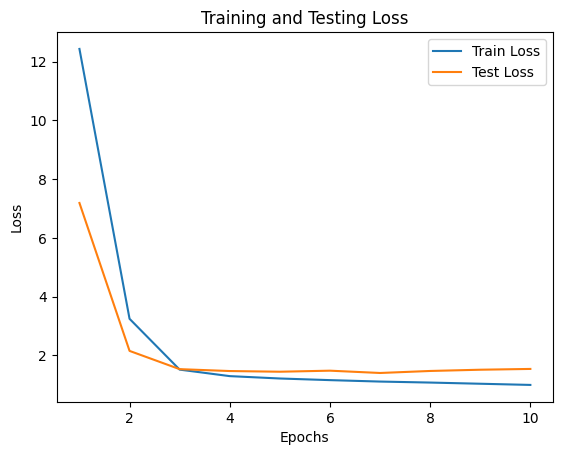

In [6]:
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

In [ ]:
def check_accuracy(loader, model):

  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:

      x=x.type(torch.cuda.FloatTensor)
      y=y.type(torch.cuda.FloatTensor)

      scores = model(x) 
      _, predictions = scores.max(1)
      num_correct += (predictions==y).sum()
      num_samples += predictions.size(0)

  print(f'got {num_correct} / {num_samples}   Accuracy {(float(num_correct)/float(num_samples)*100)}')

  model.train()

In [8]:
check_accuracy(trainloader, model)
check_accuracy(testloader, model)

got 33581 / 50000   Accuracy 67.162
got 5173 / 10000   Accuracy 51.73


<Axes: >

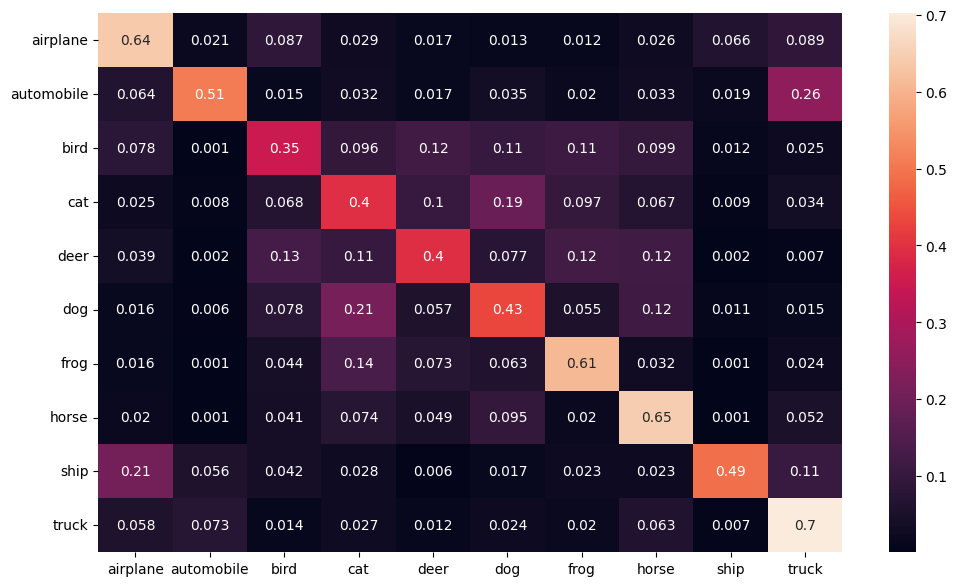

In [9]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm/np.sum(cm) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)